<a href="https://colab.research.google.com/github/dalga04/DS002/blob/main/Copy_of_Untitled14.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, mean_squared_error
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from imblearn.over_sampling import SMOTE
import shap

orders = pd.read_csv('orders.csv')
products = pd.read_csv('products (1).csv')
order_products_prior = pd.read_csv('order_products__prior.csv')
order_products = pd.read_csv('order_products__train.csv')
aisles = pd.read_csv('aisles.csv')
departments = pd.read_csv('departments.csv')

order_products_full = order_products.merge(orders, on='order_id', how='left')
order_products_full = order_products_full.merge(products, on='product_id', how='left')
order_products_full = order_products_full.merge(aisles, on='aisle_id', how='left')
order_products_full = order_products_full.merge(departments, on='department_id', how='left')

order_products_full.head()


,order_id,product_id,add_to_cart_order,reordered,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order,product_name,aisle_id,department_id,aisle,department
0,1,49302,1,1,112108,train,4,4,10,9.0,Bulgarian Yogurt,120,16,yogurt,dairy eggs
1,1,11109,2,1,112108,train,4,4,10,9.0,Organic 4% Milk Fat Whole Milk Cottage Cheese,108,16,other creams cheeses,dairy eggs
2,1,10246,3,0,112108,train,4,4,10,9.0,Organic Celery Hearts,83,4,fresh vegetables,produce
3,1,49683,4,0,112108,train,4,4,10,9.0,Cucumber Kirby,83,4,fresh vegetables,produce
4,1,43633,5,1,112108,train,4,4,10,9.0,Lightly Smoked Sardines in Olive Oil,95,15,canned meat seafood,canned goods


   order_id  product_id  add_to_cart_order  reordered  user_id eval_set  \
0         1       49302                  1          1   112108    train   
1         1       11109                  2          1   112108    train   
2         1       10246                  3          0   112108    train   
3         1       49683                  4          0   112108    train   
4         1       43633                  5          1   112108    train   

   order_number  order_dow  order_hour_of_day  days_since_prior_order  \
0             4          4                 10                     9.0   
1             4          4                 10                     9.0   
2             4          4                 10                     9.0   
3             4          4                 10                     9.0   
4             4          4                 10                     9.0   

                                    product_name  aisle_id  department_id  \
0                               B

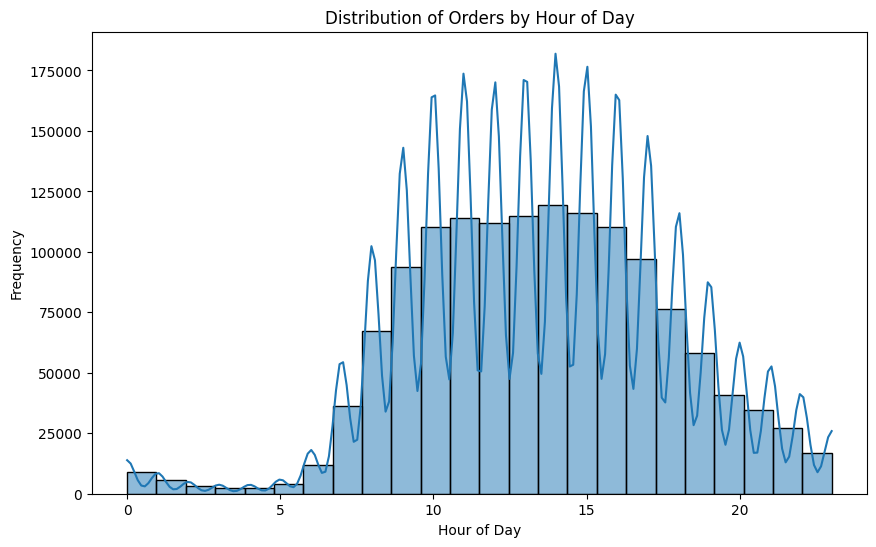

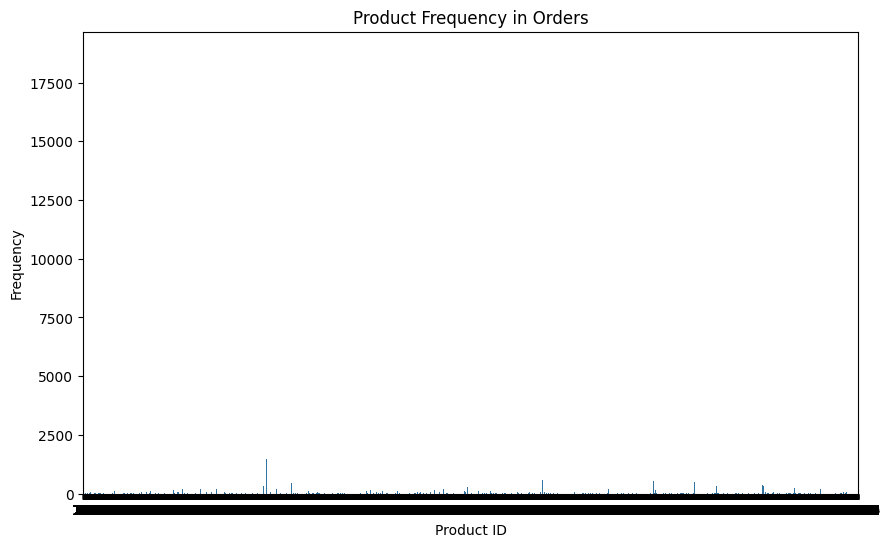

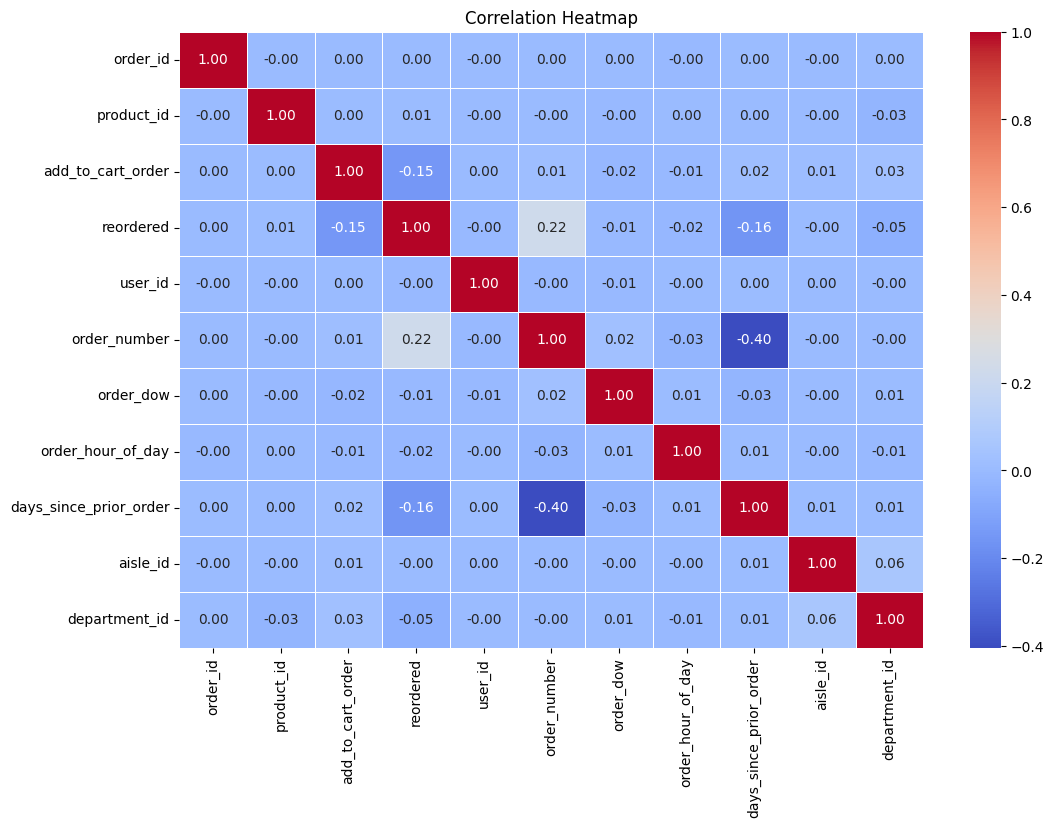

In [ ]:
order_products_full = order_products.merge(orders, on='order_id', how='left')
order_products_full = order_products_full.merge(products, on='product_id', how='left')
order_products_full = order_products_full.merge(aisles, on='aisle_id', how='left')
order_products_full = order_products_full.merge(departments, on='department_id', how='left')

# عرض البيانات بعد الدمج
print(order_products_full.head())

# فحص القيم المفقودة
missing_values = order_products_full.isnull().sum()
print("Missing Values:\n", missing_values)

# تحليل التوزيعات
plt.figure(figsize=(10, 6))
sns.histplot(order_products_full['order_hour_of_day'], kde=True, bins=24)
plt.title('Distribution of Orders by Hour of Day')
plt.xlabel('Hour of Day')
plt.ylabel('Frequency')
plt.show()

# رسم تفاعل المنتج مع الطلبات
plt.figure(figsize=(10, 6))
sns.countplot(data=order_products_full, x='product_id')
plt.title('Product Frequency in Orders')
plt.xlabel('Product ID')
plt.ylabel('Frequency')
plt.show()

# تحديد الأعمدة الرقمية فقط لحساب الارتباط
numeric_cols = order_products_full.select_dtypes(include=[np.number])

# حساب مصفوفة الارتباط للأعمدة الرقمية فقط
corr_matrix = numeric_cols.corr()

# عرض مصفوفة الارتباط
plt.figure(figsize=(12, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title('Correlation Heatmap')
plt.show()

In [ ]:
order_products_full['product_name'] = order_products_full['product_name'].fillna('Unknown')

imputer = SimpleImputer(strategy='most_frequent')

order_products_full['product_id'] = imputer.fit_transform(order_products_full[['product_id']])

from scipy.stats import zscore
order_products_full['product_id_zscore'] = zscore(order_products_full['product_id'])
order_products_full = order_products_full[order_products_full['product_id_zscore'].abs() < 3]

order_products_full.drop(columns=['product_name'], inplace=True)

X = order_products_full.drop(columns=['reordered'])
y = order_products_full['reordered']


In [ ]:
# ميزات المستخدم
user_features = order_products_full.groupby('user_id').agg({
    'order_id': 'count',  # إجمالي عدد الطلبات
    'reordered': 'mean',  # نسبة إعادة الطلبات
}).rename(columns={'order_id': 'total_orders', 'reordered': 'reorder_ratio'})

# ميزات المنتج
product_features = order_products_full.groupby('product_id').agg({
    'order_id': 'count',  # عدد مرات شراء المنتج
    'reordered': 'mean',  # معدل إعادة الطلب للمنتج
}).rename(columns={'order_id': 'total_sales', 'reordered': 'product_reorder_rate'})

# دمج الميزات الجديدة مع مجموعة البيانات الأصلية
X = X.merge(user_features, on='user_id', how='left')
X = X.merge(product_features, on='product_id', how='left')

# إضافة ميزات مؤقتة
X['order_dow'] = X['order_dow'].astype('category')
X['order_hour_of_day'] = X['order_hour_of_day'].astype('category')


In [ ]:
from sklearn.preprocessing import OneHotEncoder

# تشفير البيانات الفئوية (One-Hot Encoding)
encoder = OneHotEncoder(sparse_output=False, drop='first')  # استخدام sparse_output بدلاً من sparse
encoded_features = encoder.fit_transform(X[['order_dow', 'order_hour_of_day']])

# دمج الميزات المشفرة مع الميزات الأصلية
encoded_df = pd.DataFrame(encoded_features, columns=encoder.get_feature_names_out())
X = pd.concat([X, encoded_df], axis=1)

# إزالة الأعمدة الأصلية بعد الترميز
X.drop(columns=['order_dow', 'order_hour_of_day'], inplace=True)

# عرض البيانات بعد إضافة الميزات المشفرة
print(X.head())


   order_id  product_id  add_to_cart_order  user_id eval_set  order_number  \
0         1       49302                  1   112108    train             4   
1         1       11109                  2   112108    train             4   
2         1       10246                  3   112108    train             4   
3         1       49683                  4   112108    train             4   
4         1       43633                  5   112108    train             4   

   days_since_prior_order  aisle_id  department_id                 aisle  ...  \
0                     9.0       120             16                yogurt  ...   
1                     9.0       108             16  other creams cheeses  ...   
2                     9.0        83              4      fresh vegetables  ...   
3                     9.0        83              4      fresh vegetables  ...   
4                     9.0        95             15   canned meat seafood  ...   

  order_hour_of_day_14  order_hour_of_day_15

In [ ]:
from sklearn.preprocessing import StandardScaler

# اختيار الأعمدة الرقمية فقط
numeric_cols = X.select_dtypes(include=[np.number])

# تطبيق التحجيم (scaling) على الأعمدة الرقمية فقط
scaler = StandardScaler()
X_scaled = scaler.fit_transform(numeric_cols)

# تقسيم البيانات إلى مجموعة تدريب واختبار
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42, stratify=y)

# عرض شكل البيانات بعد التقسيم
print(f"X_train shape: {X_train.shape}, X_test shape: {X_test.shape}")
print(f"y_train shape: {y_train.shape}, y_test shape: {y_test.shape}")


X_train shape: (1107693, 42), X_test shape: (276924, 42)
y_train shape: (1107693,), y_test shape: (276924,)


In [ ]:
# تقسيم البيانات إلى ميزات (features) وهدف (target)
X = order_products_full.drop(columns=['reordered'])  # X هو مجموعة الميزات
y = order_products_full['reordered']  # y هو الهدف

# اختيار الأعمدة الرقمية فقط
numeric_cols = X.select_dtypes(include=[np.number])

# تطبيق التحجيم (scaling) على الأعمدة الرقمية فقط
scaler = StandardScaler()
X_scaled = scaler.fit_transform(numeric_cols)

# تقسيم البيانات إلى مجموعة تدريب واختبار
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42, stratify=y)

# إنشاء نموذج KNN مع عدد الجيران المحدد (n_neighbors)
knn = KNeighborsClassifier(n_neighbors=5)

# تدريب النموذج باستخدام بيانات التدريب
knn.fit(X_train, y_train)

# التنبؤ بالنتائج باستخدام بيانات الاختبار
y_pred_knn = knn.predict(X_test)

# تقييم أداء النموذج
print("KNN Performance:")
print(f"Accuracy: {accuracy_score(y_test, y_pred_knn):.4f}")
print(f"Precision: {precision_score(y_test, y_pred_knn):.4f}")
print(f"Recall: {recall_score(y_test, y_pred_knn):.4f}")
print(f"F1 Score: {f1_score(y_test, y_pred_knn):.4f}")

KNN Performance:
Accuracy: 0.6292
Precision: 0.6739
Recall: 0.7374
F1 Score: 0.7042


In [ ]:
# تدريب نموذج الشجرة العشوائية (Random Forest)
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

# تدريب نموذج XGBoost
from xgboost import XGBClassifier
xgb_model = XGBClassifier(n_estimators=100, random_state=42)
xgb_model.fit(X_train, y_train)

# تدريب نموذج الانحدار اللوجستي (Logistic Regression)
lr_model = LogisticRegression(max_iter=1000, random_state=42)
lr_model.fit(X_train, y_train)


LogisticRegression(max_iter=1000, random_state=42)

In [ ]:
# التنبؤات
y_pred_rf = rf_model.predict(X_test)
y_pred_xgb = xgb_model.predict(X_test)
y_pred_lr = lr_model.predict(X_test)

# حساب الدقة والقياسات الأخرى
def evaluate_model(y_true, y_pred):
    print(f"Accuracy: {accuracy_score(y_true, y_pred):.4f}")
    print(f"Precision: {precision_score(y_true, y_pred):.4f}")
    print(f"Recall: {recall_score(y_true, y_pred):.4f}")
    print(f"F1 Score: {f1_score(y_true, y_pred):.4f}")
    print(f"ROC AUC: {roc_auc_score(y_true, y_pred):.4f}")

print("Random Forest Evaluation:")
evaluate_model(y_test, y_pred_rf)

print("\nXGBoost Evaluation:")
evaluate_model(y_test, y_pred_xgb)

print("\nLogistic Regression Evaluation:")
evaluate_model(y_test, y_pred_lr)


Random Forest Evaluation:
Accuracy: 0.6922
Precision: 0.7177
Recall: 0.8009
F1 Score: 0.7570
ROC AUC: 0.6655

XGBoost Evaluation:
Accuracy: 0.6900
Precision: 0.7126
Recall: 0.8079
F1 Score: 0.7573
ROC AUC: 0.6611

Logistic Regression Evaluation:
Accuracy: 0.6494
Precision: 0.6602
Recall: 0.8536
F1 Score: 0.7446
ROC AUC: 0.5992


In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier

# تحديد الشبكة المحتملة للمعلمات (Hyperparameters) لـ Random Forest
param_grid_rf = {
    'n_estimators': [100, 200, 300],  # عدد الأشجار
    'max_depth': [None, 10, 20, 30],  # عمق الشجرة
    'min_samples_split': [2, 5, 10],  # الحد الأدنى من العينات لتقسيم العقد
    'min_samples_leaf': [1, 2, 4],  # الحد الأدنى من العينات في الورقة
    'bootstrap': [True, False]  # استخدام التكرار (Bootstrap) أم لا
}

# تطبيق GridSearchCV على نموذج Random Forest
grid_search_rf = GridSearchCV(estimator=RandomForestClassifier(random_state=42),
                              param_grid=param_grid_rf,
                              cv=5, n_jobs=-1, verbose=2)

# تدريب GridSearchCV
grid_search_rf.fit(X_train, y_train)

# الحصول على أفضل المعلمات
print("أفضل المعلمات لـ Random Forest:", grid_search_rf.best_params_)

# إعادة تدريب النموذج باستخدام أفضل المعلمات
best_rf_model = grid_search_rf.best_estimator_

# التنبؤ بالنتائج باستخدام البيانات الاختبارية
y_pred_rf = best_rf_model.predict(X_test)

# تقييم الأداء
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
print("Random Forest Evaluation after GridSearchCV:")
print(f"Accuracy: {accuracy_score(y_test, y_pred_rf):.4f}")
print(f"Precision: {precision_score(y_test, y_pred_rf):.4f}")
print(f"Recall: {recall_score(y_test, y_pred_rf):.4f}")
print(f"F1 Score: {f1_score(y_test, y_pred_rf):.4f}")


Fitting 5 folds for each of 216 candidates, totalling 1080 fits


In [ ]:
import shap
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import numpy as np

# تقسيم البيانات إلى ميزات (features) وهدف (target)
X = order_products_full.drop(columns=['reordered'])  # X هو مجموعة الميزات
y = order_products_full['reordered']  # y هو الهدف

# اختيار الأعمدة الرقمية فقط
numeric_cols = X.select_dtypes(include=[np.number])

# تطبيق التحجيم (scaling) على الأعمدة الرقمية فقط
scaler = StandardScaler()
X_scaled = scaler.fit_transform(numeric_cols)

# تقسيم البيانات إلى مجموعة تدريب واختبار
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42, stratify=y)

# إنشاء نموذج Random Forest
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)

# تدريب النموذج باستخدام بيانات التدريب
rf_model.fit(X_train, y_train)

# شرح باستخدام SHAP
explainer_rf = shap.TreeExplainer(rf_model)
shap_values_rf = explainer_rf.shap_values(X_test)

# رسم ملخص SHAP
shap.summary_plot(shap_values_rf, X_test)

# رسم تأثير الخصائص
shap.dependence_plot("total_orders", shap_values_rf, X_test)


In [ ]:
from sklearn.model_selection import train_test_split
import numpy as np
from sklearn.metrics import accuracy_score

# تقسيم البيانات إلى ميزات (features) وهدف (target)
X = order_products_full.drop(columns=['reordered'])  # X هو مجموعة الميزات
y = order_products_full['reordered']  # y هو الهدف

# تطبيق التحجيم (scaling) على الأعمدة الرقمية فقط
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X.select_dtypes(include=[np.number]))

# تقسيم البيانات إلى مجموعة تدريب واختبار
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42, stratify=y)

# إضافة ضوضاء إلى البيانات للتحقق من الاستقرار
X_train_noisy = X_train + np.random.normal(0, 0.1, X_train.shape)  # إضافة ضوضاء عشوائية
y_pred_noisy = rf_model.predict(X_train_noisy)  # التنبؤ باستخدام البيانات مع الضوضاء

# تقييم أداء النموذج مع الضوضاء
print(f"Accuracy with noise: {accuracy_score(y_train, y_pred_noisy):.4f}")
